## P7 - Prep the data 

---

In [1]:
import random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

from rich.pretty import pprint

%load_ext rich

import warnings

warnings.filterwarnings("ignore")


---

## Kernel Kaggle

#### Load and prepare data

In [ ]:
def load_data(filepath, label, print_shape=True):
    """Load data and print its shape."""
    data = pd.read_csv(filepath)
    if print_shape:
        print(f"{label} data shape: ", data.shape)
    return data


def add_feature_engineering(df):
    """Add feature engineering columns to the DataFrame."""
    df["CREDIT_INCOME_PERCENT"] = df["AMT_CREDIT"] / df["AMT_INCOME_TOTAL"]
    df["ANNUITY_INCOME_PERCENT"] = df["AMT_ANNUITY"] / df["AMT_INCOME_TOTAL"]
    df["CREDIT_TERM"] = df["AMT_ANNUITY"] / df["AMT_CREDIT"]
    df["DAYS_EMPLOYED_PERCENT"] = df["DAYS_EMPLOYED"] / df["DAYS_BIRTH"]
    return df


def handle_anomalous_days_employed(df):
    """Handle anomalous values in the DAYS_EMPLOYED column"""
    df["DAYS_EMPLOYED_ANOM"] = df["DAYS_EMPLOYED"] == 365243
    df["DAYS_EMPLOYED"].replace({365243: np.nan})
    df["DAYS_EMPLOYED_ANOM"] = df["DAYS_EMPLOYED_ANOM"].astype("int32")
    return df


# Load training and testing data
app_train = load_data("../../data/raw/application_train.csv", "Training")
app_test = load_data("../../data/raw/application_test.csv", "Testing")

# Copy data for feature engineering
app_train_domain = app_train.copy()
app_test_domain = app_test.copy()

# Add feature engineering columns
app_train_domain = add_feature_engineering(app_train_domain)
app_test_domain = add_feature_engineering(app_test_domain)

# Handle anomalous values in DAYS_EMPLOYED
app_train_domain = handle_anomalous_days_employed(app_train_domain)
app_test_domain = handle_anomalous_days_employed(app_test_domain)

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)


In [121]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer


def cleaning(features, test_features, print_shape=True):
    """Fonction cleaning finale using sklearn Pipeline"""
    # Extract the labels for training
    labels = features["TARGET"]

    # # Remove the ids and target
    if "SK_ID_CURR" in features.columns:
        features = features.drop(columns=["SK_ID_CURR", "TARGET"])
    else:
        features = features.drop(columns=["TARGET"])

    if "SK_ID_CURR" in test_features.columns:
        test_features = test_features.drop(columns=["SK_ID_CURR"])

    categorical_columns = features.select_dtypes(
        include=["object", "category"]
    ).columns.tolist()
    numerical_columns = features.select_dtypes(
        include=["int64", "float64"]
    ).columns.tolist()

    # preprocessing pipelines
    numerical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", MinMaxScaler(feature_range=(0, 1))),
        ]
    )

    categorical_pipeline = Pipeline(
        [
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore")),
        ]
    )

    # Combine the preprocessing pipelines
    preprocessor = ColumnTransformer(
        [
            ("numerical", numerical_pipeline, numerical_columns),
            ("categorical", categorical_pipeline, categorical_columns),
        ]
    )

    # Fit the preprocessor to the training data and transform both datasets
    features_transformed = preprocessor.fit_transform(features)
    test_features_transformed = preprocessor.transform(test_features)

    # Get feature names after one-hot encoding
    # First, get numerical feature names directly
    feature_names = numerical_columns.copy()

    # Then add categorical feature names after one-hot encoding
    if categorical_columns:
        ohe = preprocessor.named_transformers_["categorical"].named_steps["encoder"]
        categorical_feature_names = ohe.get_feature_names_out(categorical_columns)
        feature_names.extend(categorical_feature_names)

    if print_shape:
        print("Training Data Shape: ", features_transformed.shape)
        print("Testing Data Shape: ", test_features_transformed.shape)

    return (
        feature_names,
        labels,
        features_transformed,
        test_features_transformed,
        preprocessor,
    )

In [123]:
liste_features, y_train, X_train, X_test, pipeline = cleaning(
    app_train_domain, app_test_domain
)

train_final = pd.DataFrame(X_train, columns=liste_features)
train_final["LABELS"] = y_train

test_final = pd.DataFrame(X_test, columns=liste_features)

Training Data Shape:  (307511, 248)
Testing Data Shape:  (48744, 248)


We create a test and train set from the train and test set we obtain.  

We don't have true label for the test set, thus we will use the train set to train and evaluate our models.  
To do so, we split it into train and test.  
We will create **X_train_split**, **y_train_split**, **X_val** and **y_val**

In [6]:
from sklearn.model_selection import train_test_split

X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

---

## Models

---

In [7]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from scipy.stats import uniform, randint
from sklearn.metrics import (
    precision_score,
    recall_score,
    make_scorer,
    fbeta_score,
    roc_auc_score,
    confusion_matrix,
)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Model class
class Model:
    def __init__(self, name, estimator, params):
        """
        Parameters:
        - name: str, name of the model
        - estimator: sklearn estimator object
        - params: dict, parameters for grid search
        """

        self.name = name
        self.estimator = estimator
        self.params = params
        self.best_model = None

        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.y_pred = None
        self.y_pred_binary = None

        self.results = None
        self.best_threshold = None
        self.min_cost = None

    def load_data(self, X_train, X_test, y_train, y_test):
        """Load training and testing data."""
        self.X_train = X_train
        self.X_test = X_test
        self.y_train = y_train
        self.y_test = y_test

    def find_best_params(self, cv=5, beta=10, search_type="grid", use_smote=False):
        """
        2 methods: GridSearchCV or RandomizedSearchCV
        Possibility to use oversampling with SMOTE in an integrated pipeline to avoid data leakage
        """
        self.beta = beta

        if self.X_train is None or self.y_train is None:
            raise ValueError("Data not loaded yet. Call load_data first.")

        # The best parameters will maximize the fbeta_scorer
        fbeta_scorer = make_scorer(fbeta_score, beta=beta)

        # simple pipeline
        steps = []
        if use_smote:
            steps.append(("smote", SMOTE()))  # Add SMOTE if use_smote is True
        steps.append(("estimator", self.estimator))

        # Create the pipeline
        pipeline = Pipeline(steps)

        if search_type == "grid_search":
            param_grid = {
                f"estimator__{param}": config["values"]
                for param, config in self.params.items()
            }

            search = GridSearchCV(
                estimator=pipeline,
                param_grid=param_grid,
                cv=cv,
                scoring=fbeta_scorer,
                n_jobs=6,
            )

        elif search_type == "random_search":
            param_distributions = {}
            for param, config in self.params.items():
                if config["type"] == "int":
                    param_distributions[f"estimator__{param}"] = randint(
                        config["min"], config["max"] + 1
                    )
                elif config["type"] == "float":
                    param_distributions[f"estimator__{param}"] = uniform(
                        config["min"], config["max"] - config["min"]
                    )
                elif config["type"] == "str":
                    param_distributions[f"estimator__{param}"] = config["values"]

            search = RandomizedSearchCV(
                estimator=pipeline,
                param_distributions=param_distributions,
                cv=cv,
                scoring=fbeta_scorer,
                n_iter=100,  # Randomized search is 'always' better than grid search if n_iter is > 90
                n_jobs=-4,
            )

        else:
            raise ValueError(
                "search_type must be 'grid_search' or 'random_search' for GridSearchCV or RandomizedSearchCV"
            )

        search.fit(self.X_train, self.y_train)
        self.best_model = search.best_estimator_.steps[0][1]

        return {
            "best_params": search.best_params_,
            "best_score (fβ)": search.best_score_,
        }

    def predict_proba(self):
        # Get predictions as probabilities
        y_pred = self.best_model.predict_proba(self.X_test)
        self.y_pred = y_pred

    def find_optimal_threshold_for_min_cost(self, cost_fn=10, cost_fp=1):
        """
        Minize the total cost given the simple formula.
        Find the best threshold given the minimized total cost
        :param desired_fnr: targeted False Negative Rate (FNR).
        """
        # Get predictions as probabilities
        self.predict_proba()

        thresholds = np.linspace(0, 1, 1000)
        min_cost = float("inf")
        best_threshold = 0.5

        for threshold in thresholds:
            y_pred_binary = (self.y_pred[:, 1] >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(self.y_test, y_pred_binary).ravel()

            # Simple cost function that directly depends on the costs ratios to determine the importance of FP or FN.
            # In our case, a False Negative cost much ore that a False positive.
            total_cost = (fp * cost_fp) + (fn * cost_fn)

            if total_cost < min_cost:
                min_cost = total_cost
                best_threshold = threshold
                best_y_pred_binary = y_pred_binary

        y_pred_binary = (self.y_pred[:, 1] >= best_threshold).astype(int)

        self.y_pred_binary = best_y_pred_binary
        self.best_threshold = best_threshold
        self.min_cost = min_cost

        print(f"best_threshold: {best_threshold:.4f}, minimized cost: {min_cost:.4f}")

    def evaluate(self, metrics=None):
        """
        Evaluate the best model on the test set using multiple metrics.
        Parameters: metrics : List of metric names to calculate'
        Returns: Dictionary containing the scores for all requested metrics
        """
        if self.best_model is None:
            raise ValueError("Model not trained yet. Call find_best_params first.")

        results = {}

        if metrics is None:
            metrics = ["fbeta", "precision", "recall", "roc_auc"]

        # Calculate requested metrics
        for metric in metrics:
            if metric == "fbeta":
                results["fbeta"] = fbeta_score(
                    self.y_test, self.y_pred_binary, beta=self.beta
                )
            elif metric == "precision":
                results["precision"] = precision_score(self.y_test, self.y_pred_binary)
            elif metric == "recall":
                results["recall"] = recall_score(self.y_test, self.y_pred_binary)
            elif metric == "roc_auc":
                results["roc_auc"] = roc_auc_score(self.y_test, self.y_pred_binary)

        print(f"(β={self.beta}) score: {results}")

        self.results = results

    def get_model_info(self):
        """
        Returns a dictionary containing the model's information.
        """
        return {
            "name": self.name,
            "estimator": self.estimator,
            "params": self.params,
            "best_model": self.best_model,
            "X_train": self.X_train,
            "X_test": self.X_test,
            "y_train": self.y_train,
            "y_pred": self.y_pred,
            "y_pred_binary": self.y_pred_binary,
            "results": self.results,
            "min_cost": self.min_cost,
            "best_threshold": self.best_threshold,
        }


5 steps :  
1. load data with **.load_data**   
2. find best params with GridSearchCV using **.find_best_params**  
3. get the minimized cost for the best_model and the corresponding classification threshold with **.find_optimal_threshold_for_min_cost**  
4. evaluate on test set with **.evaluate**  
5. Retreive the info for each model wth the **.get_model_info** (usefull to log into mlflow)  


In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [9]:
dummy_model = Model(
    name="Dummy Classifier",
    estimator=DummyClassifier(random_state=42),
    params={
        "strategy": {
            "type": "str",
            "values": ["most_frequent", "stratified", "uniform"],
        }
    },
)

logistic_model = Model(
    name="Logistic Regression",
    estimator=LogisticRegression(random_state=42, verbose=1, n_jobs=1),
    params={
        "C": {"type": "float", "values": np.logspace(0, 1, num=10).tolist()},
        "tol": {"type": "int", "values": [0.001, 0.01]},
    },
)

random_forest = Model(
    name="Random_forest_classifier",
    estimator=RandomForestClassifier(random_state=42, verbose=1, n_jobs=1),
    params={
        "n_estimators": {
            "type": "int",
            "min": 100,
            "max": 200,
            "values": [100, 200],
        },
        "min_samples_split": {
            "type": "int",
            "min": 2,
            "max": 5,
            "values": [2, 3, 5],
        },
        "min_samples_leaf": {
            "type": "int",
            "min": 1,
            "max": 3,
            "values": [1, 2, 3],
        },
    },
)

lgbm_model = Model(
    name="LightGBM Classifier",
    estimator=LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
    params={
        "learning_rate": {
            "type": "float",
            "values": [0.01, 0.05, 0.1],
            "min": 0.01,
            "max": 0.1,
        },
        "n_estimators": {"type": "int", "values": [100, 200], "min": 100, "max": 200},
        "max_depth": {"type": "int", "values": [3, 5, 7], "min": 3, "max": 7},
    },
)
# n_jobs are set to 1 to avoid nested parallelization between the model's n_job and the grid_search one.
# Parallelization is done at the gridsearch level.

In [76]:
def process_model(
    model_name, beta=10, search_type="grid_search", cost_fn=10, cost_fp=1
):
    """All the steps to do to run the different functions of the class Model, and to get the results"""

    # 1. Load the data
    model_name.load_data(X_train_split, X_val, y_train_split, y_val)

    # 2. Find best parameters
    best_params = model_name.find_best_params(beta=beta, search_type=search_type)
    pprint(best_params)
    print(f"{model_name.name}:")

    # 3. Min cost and optimal threshold
    model_name.find_optimal_threshold_for_min_cost(cost_fn=cost_fn, cost_fp=cost_fp)

    # 4. Evaluate the model
    model_name.evaluate()


In [62]:
# 1. Load the data
dummy_model.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{dummy_model.name}:")
pprint(dummy_model.find_best_params(beta=10, search_type="random_search"))

# 3. min cost and optimal threshold
dummy_model.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
dummy_model.evaluate()

{
│   'best_params': {'estimator__strategy': 'uniform'},
│   'best_score (fβ)': np.float64(0.47609782575933635)
}
Dummy Classifier:
best_threshold: 0.5005, minimized cost: 49490.0000
(β=10) score: {'fbeta': 0.0, 'precision': 0.0, 'recall': 0.0, 'roc_auc': np.float64(0.5)}


In [69]:
# 1. Load the data
logistic_model.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{logistic_model.name}:")
pprint(logistic_model.find_best_params(beta=10, search_type="grid_search"))

# 3. min cost and optimal threshold
logistic_model.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
logistic_model.evaluate()

Logistic Regression:
{
│   'best_params': {'C': 4.641588833612778, 'tol': 0.001},
│   'best_score': np.float64(0.01016076607046979)
}
best_threshold: 0.1041, minimized cost: 33925.0000
(β=10) score: {'fbeta': 0.5480332940338708, 'precision': 0.1861247560729426, 'recall': 0.5589007880379875, 'roc_auc': np.float64(0.6725171974281249)}


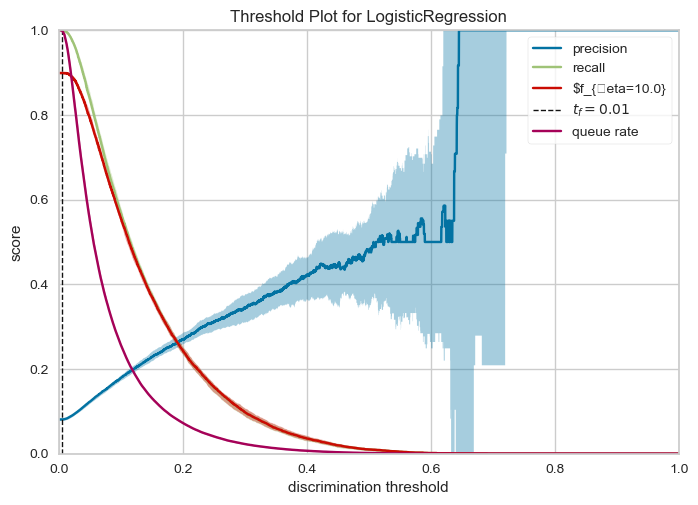

<Axes: title={'center': 'Threshold Plot for LogisticRegression'}, xlabel='discrimination threshold', ylabel='score'>

In [ ]:
from yellowbrick.classifier import DiscriminationThreshold

visualizer = DiscriminationThreshold(
    logistic_model.best_model, fbeta=logistic_model.beta
)

visualizer.fit(logistic_model.X_train, logistic_model.y_train)
visualizer.show()

In [10]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

# 1. Load the data
lgbm_model.load_data(X_train_split, X_val, y_train_split, y_val)

# 2. Find best parameters
print(f"{lgbm_model.name}:")
pprint(lgbm_model.find_best_params(beta=10, search_type="grid_search"))

# 3. min cost and optimal threshold
lgbm_model.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
lgbm_model.evaluate()

LightGBM Classifier:


/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklea

{
│   'best_params': {
│   │   'estimator__learning_rate': 0.1,
│   │   'estimator__max_depth': 7,
│   │   'estimator__n_estimators': 200
│   },
│   'best_score (fβ)': np.float64(0.025902995434314312)
}
best_threshold: 0.0951, minimized cost: 32064.0000
(β=10) score: {'fbeta': 0.6105582557489354, 'precision': 0.18642228385385265, 'recall': 0.6247726813497676, 'roc_auc': np.float64(0.6930844345320823)}


---

### Features importance (best model)

In [35]:
def feature_importance_lgb(print_top_15=False, barplot_top_15=True):
    # var name from the final test set (preprocessed)
    test_colnames = test_final.columns.to_list()
    # we need to remove the id var that was not used in the trainning
    test_colnames.remove("SK_ID_CURR")

    lgbm_model.feature_name_ = test_colnames

    # Get the original feature importances
    feature_importance_lgb = pd.DataFrame(
        {
            "feature": lgbm_model.feature_name_,
            "importance": lgbm_model.best_model.feature_importances_,
        }
    ).sort_values("importance", ascending=False)

    # Get the original categorical feature names (before one-hot encoding)
    categorical_features = pipeline.feature_names_in_

    # Create a mapping from encoded feature names to original feature names
    feature_mapping = {}

    # Process each feature in our importance dataframe
    for feature in feature_importance_lgb["feature"]:
        # Check if this feature is one-hot encoded
        for cat_feature in categorical_features:
            # One-hot encoded features typically start with the original feature name
            if feature.startswith(cat_feature + "_"):
                feature_mapping[feature] = cat_feature
                break

    # Apply the mapping to get original feature names
    feature_importance_lgb["original_feature"] = feature_importance_lgb["feature"].map(
        feature_mapping
    )

    # Aggregate importances by original feature names
    aggregated_importance = (
        feature_importance_lgb.groupby("original_feature")["importance"]
        .sum()
        .reset_index()
    )

    # Sort by importance in descending order
    aggregated_importance = aggregated_importance.sort_values(
        "importance", ascending=False
    )
    top_15_features = aggregated_importance.head(15)

    if print_top_15:
        # Show the top 10 most important features
        print("Top 10 most important features (aggregated):")
        print(top_15_features)

    if barplot_top_15:
        plt.figure(figsize=(10, 6))
        sns.barplot(x="importance", y="original_feature", data=top_15_features)
        plt.title("Top 15 Most Important Features (Aggregated)")
        plt.tight_layout()
        plt.show()

    return top_15_features

Top 10 most important features (aggregated):
              original_feature  importance
14           ORGANIZATION_TYPE         204
1                DAYS_EMPLOYED         174
13             OCCUPATION_TYPE          85
9           NAME_FAMILY_STATUS          69
8          NAME_EDUCATION_TYPE          67
0                  CODE_GENDER          61
17  WEEKDAY_APPR_PROCESS_START          52
3                 FLAG_OWN_CAR          40
7           NAME_CONTRACT_TYPE          37
11            NAME_INCOME_TYPE          35
10           NAME_HOUSING_TYPE          31
15        REGION_RATING_CLIENT          28
16          WALLSMATERIAL_MODE          25
12             NAME_TYPE_SUITE          21
4              FLAG_OWN_REALTY          13


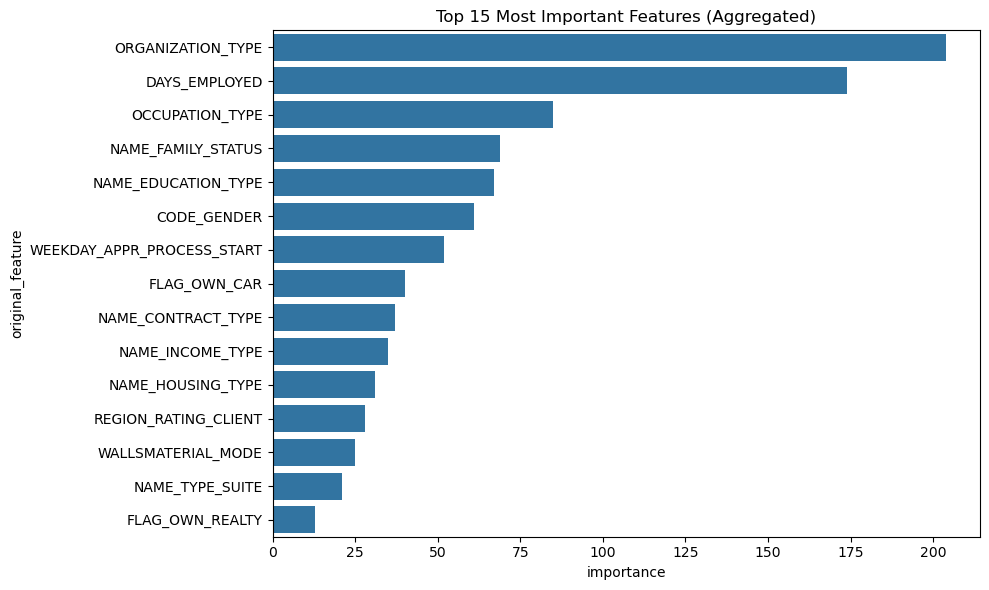

In [36]:
top_15_features_df = feature_importance_lgb(print_top_15=True)

#### SHAP values

In [16]:
import shap
from typing import Literal


def shap_feature_importance(
    level: Literal["global", "local"] = "global",
    model=lgbm_model.best_model,
    test_data=X_test,
    features_names=lgbm_model.feature_name_,
    obs_index=None,
    top_n=10,
) -> None:
    """
    This function can return 2 SHAP plots:
    - summary_plot for the model SHAP values
    - bar plot for the single obs SHAP values
    """
    if level not in ["global", "local"]:
        raise ValueError(
            "'level' can be either 'global' for the model SHAP or 'local' for a given obs SHAP."
        )
    explainer = shap.TreeExplainer(model)

    shap_values = explainer.shap_values(test_data)

    if level == "global":
        obs_index = None
        shap.summary_plot(shap_values, features=test_data, feature_names=features_names)

    elif level == "local":
        if obs_index is None:
            raise ValueError("'obs_index' must be provided when 'level' is 'local'.")

        # Get SHAP values for that specific observation
        single_obs_shap_values = (
            shap_values[1][obs_index]
            if isinstance(shap_values, list)
            else shap_values[obs_index]
        )
        shap_explanation = shap.Explanation(
            values=single_obs_shap_values, data=features_names
        )
        print(f"Top {top_n} important features for observation {obs_index}:")
        for i in range(top_n):
            feature_idx = features_names[i]
            importance = single_obs_shap_values[feature_idx]
            print(f"Feature {feature_idx}: SHAP value = {importance:.4f}")

        # bar plot
        shap.plots.bar(shap_explanation, max_display=top_n)


Top 10 important features for observation 0:
Feature 29: SHAP value = 0.9570
Feature 28: SHAP value = -0.9281
Feature 27: SHAP value = -0.4561
Feature 4: SHAP value = 0.1023
Feature 132: SHAP value = -0.0809
Feature 3: SHAP value = -0.0674
Feature 9: SHAP value = 0.0576
Feature 113: SHAP value = 0.0479
Feature 200: SHAP value = -0.0468
Feature 2: SHAP value = 0.0431


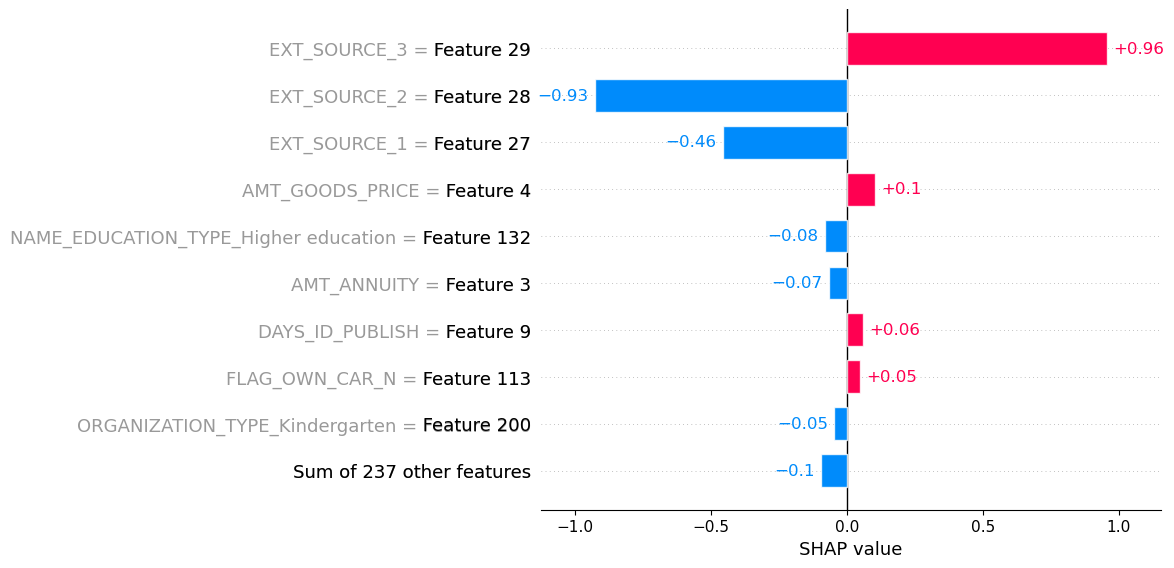

In [329]:
shap_feature_importance(level="local", obs_index=0)

---

In [ ]:
top_15_features_names = top_15_features_df["original_feature"].tolist()
top_15_features_names.append("TARGET")

app_train_domain_top15 = app_train_domain[top_15_features_names]

# We removed target and added the id so we can export the app_test data with the 15 features + the id var ( for the api)
top_15_features_names.remove("TARGET")
top_15_features_names.append("SK_ID_CURR")
app_test_domain_top15 = app_test_domain[top_15_features_names]

In [153]:
_, y_train_15, X_train_15, _, preprocessor_top15 = cleaning(
    app_train_domain_top15, app_test_domain_top15
)

X_train_split_15, X_val_15, y_train_split_15, y_val_15 = train_test_split(
    X_train_15, y_train_15, test_size=0.2, random_state=42
)

Training Data Shape:  (307511, 133)
Testing Data Shape:  (48744, 133)


In [125]:
lgbm_model_15 = Model(
    name="LightGBM Classifier",
    estimator=LGBMClassifier(random_state=42, n_jobs=1, verbose=-1),
    params={
        "learning_rate": {
            "type": "float",
            "values": [0.01, 0.05, 0.1],
            "min": 0.01,
            "max": 0.1,
        },
        "n_estimators": {"type": "int", "values": [100, 200], "min": 100, "max": 200},
        "max_depth": {"type": "int", "values": [3, 5, 7], "min": 3, "max": 7},
    },
)


In [126]:
# 1. Load the data
lgbm_model_15.load_data(X_train_split_15, X_val_15, y_train_split_15, y_val_15)

# 2. Find best parameters
print(f"{lgbm_model_15.name}:")
pprint(lgbm_model_15.find_best_params(beta=10, search_type="grid_search"))

# 3. min cost and optimal threshold
lgbm_model_15.find_optimal_threshold_for_min_cost(cost_fn=10, cost_fp=1)

# 4. evalutate the model
lgbm_model_15.evaluate()

LightGBM Classifier:


/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/Users/calh/Desktop/OC/Projet7/.pixi/envs/default/lib/python3.12/site-packages/sklea

{
│   'best_params': {
│   │   'estimator__learning_rate': 0.1,
│   │   'estimator__max_depth': 7,
│   │   'estimator__n_estimators': 200
│   },
│   'best_score (fβ)': np.float64(0.0002032571478559311)
}
best_threshold: 0.0841, minimized cost: 40598.0000
(β=10) score: {'fbeta': 0.5600508522386964, 'precision': 0.12655436987388657, 'recall': 0.57991513437058, 'roc_auc': np.float64(0.6148329075679331)}


---

## Save data

In [ ]:
# Save data for the evidently Notebook

import pickle
import joblib

# save the data
joblib.dump(
    logistic_model.y_pred, "../../data/processed/logistic_y_pred.joblib", compress=True
)
joblib.dump(
    logistic_model.y_test, "../../data/processed/logistic_y_test.joblib", compress=True
)
joblib.dump(
    app_test_domain, "../../data/processed/app_test_domain.joblib", compress=True
)
joblib.dump(
    app_train_domain, "../../data/processed/app_train_domain.joblib", compress=True
)

In [ ]:
import pickle
import joblib

# save the data
joblib.dump(
    app_test_domain, "../../data/processed/app_test_domain_top15.joblib", compress=True
)
# joblib.dump(
#     app_train_domain, "../../data/processed/app_train_domain.joblib", compress=True
# )

['../../data/processed/app_test_domain_top15.joblib']

In [ ]:
# A single dictionnary to store the info of all the models. Needed to log into MLflow
models_info = [
    dummy_model.get_model_info(),
    logistic_model.get_model_info(),
    lgbm_model.get_model_info(),
]

In [ ]:
import joblib

models_info = [
    dummy_model.get_model_info(),
    lgbm_model_15.get_model_info(),
]

joblib.dump(
    models_info[1],
    "../../data/processed/lgbm_model_15_info.joblib",
    compress=True,
)
joblib.dump(
    preprocessor_top15,
    "../../data/processed/preprocessor_top15.joblib",
    compress=True,
)


['../../data/processed/preprocessor_top15.joblib']

In [ ]:
import pickle

with open("../../data/processed/lgbm_model_15.pkl", "wb") as file:
    pickle.dump(lgbm_model_15.best_model, file)

with open("../../data/processed/prep.pkl", "wb") as file:
    pickle.dump(pipeline, file)


---

# MLflow

In [ ]:
import mlflow
from mlflow.models import infer_signature


In [ ]:
# Initialize MLflow
mlflow.set_tracking_uri("http://localhost:5002")
mlflow.set_experiment("MLflow try3")
# might need to run 'mlflow server --host 127.0.0.1 --port 5002' in the terminal if issues
# if using pixi: run 'pixi shell' before the mlflow line at the root directory of the project. Needed because mlflow is installed in the project env and not in the global env, thus the CLI is not accessible in the regular shell.

for model_info in tqdm(models_info, desc="Processing models"):
    model_name = model_info["name"]
    params = model_info["params"]
    estimator = model_info["estimator"]
    best_model = model_info["best_model"]
    results = model_info["results"]
    X_test = model_info["X_test"]
    y_train = model_info["y_train"]

    # Create a sample for signature inference
    if X_test is not None:
        X_sample = X_test[:5]  # Take first 5 samples from X_test

        # Only fit if we have training data and it's not already the best model
        if y_train is not None and best_model is None:
            y_sample = y_train[:5]
            best_model.fit(X_sample, y_sample)

        signature = infer_signature(
            X_sample, best_model.predict(X_sample), params=params
        )
        input_example = X_sample
    else:
        signature = None
        input_example = None

    with mlflow.start_run(run_name=model_name):
        # Log parameters
        mlflow.log_params(params)

        # Log metrics from the results if available
        if results is not None:
            metrics_to_log = {}

            for metric_name, metric_value in results.items():
                metrics_to_log[metric_name] = metric_value

            # Log the metrics
            if metrics_to_log:
                mlflow.log_metrics(metrics_to_log)

        # Log the model,
        mlflow.sklearn.log_model(
            best_model,
            "model",
            signature=signature,
            input_example=input_example,
            registered_model_name=f"{model_name}_reg",
        )

Processing models:   0%|          | 0/3 [00:00<?, ?it/s]2025/04/15 20:09:08 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Dummy Classifier_reg' already exists. Creating a new version of this model...
2025/04/15 20:09:08 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Dummy Classifier_reg, version 7
Created version '7' of model 'Dummy Classifier_reg'.
Processing models:  33%|███▎      | 1/3 [00:02<00:05,  2.61s/it]

🏃 View run Dummy Classifier at: http://localhost:5002/#/experiments/358505659432573436/runs/ac7f9235cc3944408b1095f2cc7b9574
🧪 View experiment at: http://localhost:5002/#/experiments/358505659432573436


2025/04/15 20:09:11 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'Logistic Regression_reg' already exists. Creating a new version of this model...
2025/04/15 20:09:11 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression_reg, version 15
Created version '15' of model 'Logistic Regression_reg'.
Processing models:  67%|██████▋   | 2/3 [00:05<00:02,  2.49s/it]

🏃 View run Logistic Regression at: http://localhost:5002/#/experiments/358505659432573436/runs/eb5edbd311a14b67a8130a23d1c22dcf
🧪 View experiment at: http://localhost:5002/#/experiments/358505659432573436


2025/04/15 20:09:13 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
Registered model 'LightGBM Classifier_reg' already exists. Creating a new version of this model...
2025/04/15 20:09:13 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: LightGBM Classifier_reg, version 2
Created version '2' of model 'LightGBM Classifier_reg'.
Processing models: 100%|██████████| 3/3 [00:07<00:00,  2.52s/it]

🏃 View run LightGBM Classifier at: http://localhost:5002/#/experiments/358505659432573436/runs/4767122bce8a427aa58d43278da7bce9
🧪 View experiment at: http://localhost:5002/#/experiments/358505659432573436


In [ ]:
# mlflow.end_run()

---

In [169]:
app_test_domain_top15.columns


Index(['ORGANIZATION_TYPE', 'DAYS_EMPLOYED', 'OCCUPATION_TYPE',
       'NAME_FAMILY_STATUS', 'NAME_EDUCATION_TYPE', 'CODE_GENDER',
       'WEEKDAY_APPR_PROCESS_START', 'FLAG_OWN_CAR', 'NAME_CONTRACT_TYPE',
       'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'REGION_RATING_CLIENT',
       'WALLSMATERIAL_MODE', 'NAME_TYPE_SUITE', 'FLAG_OWN_REALTY',
       'SK_ID_CURR'],
      dtype='object')

In [ ]:
app_test_domain_top15["SK_ID_CURR"]


0        100001
1        100005
2        100013
3        100028
4        100038
          ...  
48739    456221
48740    456222
48741    456223
48742    456224
48743    456250
Name: SK_ID_CURR, Length: 48744, dtype: int64